In [25]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim

In [26]:
both_gender_1960 = pd.read_csv('data/both_gender/1960.csv')[["Origin_name",	"Origin_code","Destination_name","Destination_code","1960"]]
both_gender_1960

,Origin_name,Origin_code,Destination_name,Destination_code,1960
0,Afghanistan,AFG,Afghanistan,AFG,0
1,Afghanistan,AFG,Albania,ALB,0
2,Afghanistan,AFG,Algeria,DZA,41
3,Afghanistan,AFG,American Samoa,ASM,0
4,Afghanistan,AFG,Andorra,AND,0
...,...,...,...,...,...
53587,Zimbabwe,ZWE,Wallis and Futuna,WLF,0
53588,Zimbabwe,ZWE,West Bank and Gaza,PSE,0
53589,Zimbabwe,ZWE,"Yemen, Rep.",YEM,0
53590,Zimbabwe,ZWE,Zambia,ZMB,90416


In [27]:
country_list = both_gender_1960['Origin_name'].unique()
country_list

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Cook Islands', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Falkland Is

In [28]:
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph, with origin and destination as nodes
for _, row in both_gender_1960.iterrows():
    G.add_edge(row['Origin_name'], row['Destination_name'], weight=row['1960'])

In [29]:
def get_coordinates(country_name):
    geolocator = Nominatim(user_agent="migration_map")
    
    try:
        location = geolocator.geocode(country_name)
        if location:
            return location.latitude, location.longitude
        else:
            # If the country is not found, return None (or handle it differently)
            return None
    except Exception as e:
        print(f"Error retrieving coordinates for {country_name}: {e}")
        return None


Error retrieving coordinates for Venezuela, RB: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Venezuela%2C+RB&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retrieving coordinates for Virgin Islands (U.S.): HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Virgin+Islands+%28U.S.%29&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retrieving coordinates for Venezuela, RB: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Venezuela%2C+RB&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retr

KeyboardInterrupt: 

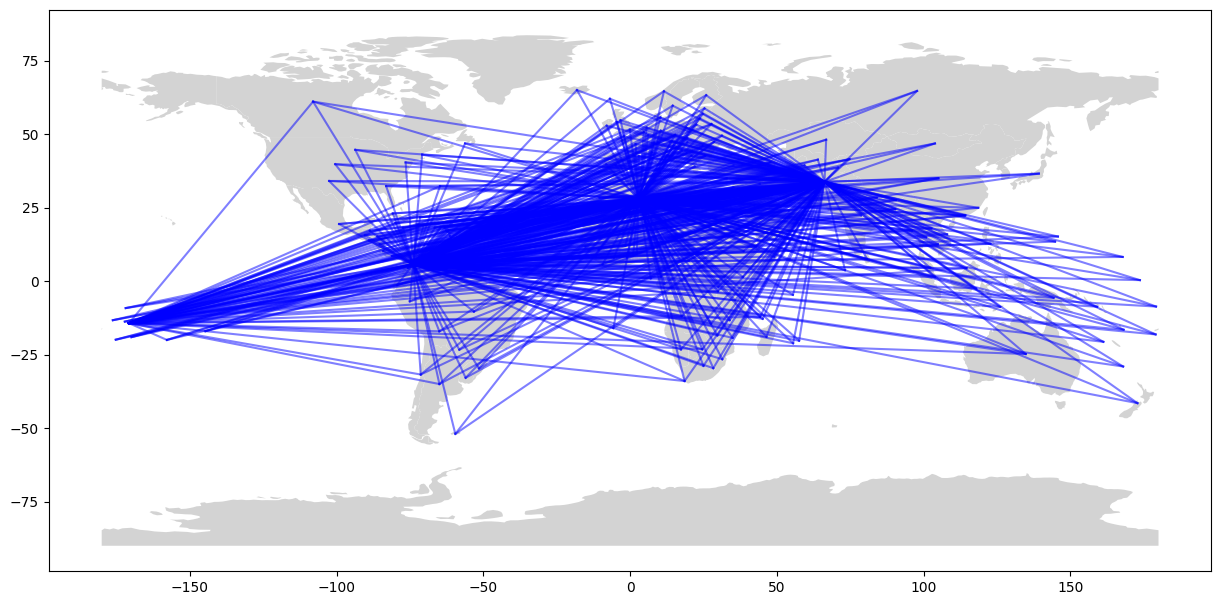

In [30]:
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Plot the world map
ax = world.plot(figsize=(15, 10), color='lightgrey')

# Add edges from the migration graph to the plot
for edge in G.edges():
    origin, destination = edge
    origin_coords = get_coordinates(origin)
    destination_coords = get_coordinates(destination)
    
    if origin_coords and destination_coords:
        # Plot the line between the origin and destination on the map
        plt.plot([origin_coords[1], destination_coords[1]], 
                 [origin_coords[0], destination_coords[0]], color='blue', alpha=0.5)

# Show the plot
plt.show()
